In [1]:
import importlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import os
from random import random, seed, uniform, gauss
import re
import sys

from sklearn.linear_model import LinearRegression


In [2]:
seed(12345)
np.random.seed(12345)

In [3]:
%matplotlib inline

pd.options.display.max_rows = 250
pd.options.display.max_columns = 125
pd.options.display.max_colwidth = 250

nx_options = {
    'node_color': 'orange',
    "edge_color": "blue",
    "with_labels": True,
    "font_weight": 'bold',
    "font_size": 12,
    'node_size': 1200,
    'width': 1,
    "arrowsize": 15,
}

num_data_elts = 1_000_000
num_bins = 50


In [4]:
dataset_dir = "."
dataset_re = re.compile(r"^dataset_0?(\d+).py")
all_datasets = [f for f in sorted(os.listdir(dataset_dir)) if dataset_re.match(f)]

print("\n".join(all_datasets))
print()

dataset_01.py
dataset_02.py
dataset_03.py



In [5]:
f=lambda x: x

dataset = f("""

dataset_01.py

""".strip())

dataset_index = int(dataset_re.match(dataset).group(1))

dataset, dataset_index

('dataset_01.py', 1)

In [6]:
module = importlib.import_module("dataset_%02d" % dataset_index)

In [7]:
setattr(sys.modules[__name__], "dataset", module)
setattr(sys.modules[__name__], "g", dataset.g)
setattr(sys.modules[__name__], "draw_fn", dataset.draw_fn)
setattr(sys.modules[__name__], "observation", dataset.observation)

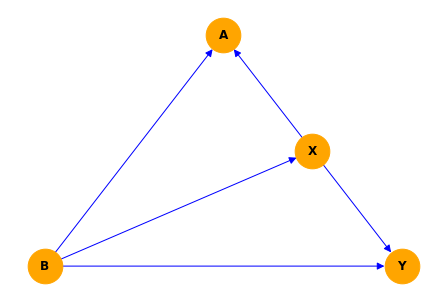

In [8]:
draw_fn(g, **nx_options)

In [9]:
data = [dataset.observation() for _ in range(num_data_elts)]
df = pd.DataFrame(data, columns=sorted(g.nodes))

In [10]:
# See the regression coefficients for predicting each variable from the others.

for node in g.nodes:
#     parents = list(g.predecessors(node))
#     print(node, parents)
    
#     if len(parents) == 0:
#         continue

    model_columns = [col for col in g.nodes if col != node]

    x_train = df[model_columns]
    y_train = df[node]
    
    model = LinearRegression().fit(x_train, y_train)

    print(node, dict(zip(model_columns, [np.round(coeff, 5) for coeff in model.coef_])))
    print()

B {'X': -0.59009, 'A': 0.48179, 'Y': -0.00091}

X {'B': -1.54783, 'A': 0.79005, 'Y': 0.00252}

A {'B': 1.9997, 'X': 1.25014, 'Y': -7e-05}

Y {'B': -0.96496, 'X': 1.02244, 'A': -0.0176}



If the variables in $Z$ satisfy the backdoor criterion

$$
P(Y=y | do(X=x)) = \sum_z P(Y=y | X=x, Z=z) P(Z=z) \\
= \sum_z \frac{P(Y=y, X=x, Z=z)}{P(X=x | Z=z)}
$$

In [11]:
def find_directed_paths(g, src, dest):
    def find_paths(node, path):
        path_extension = path + (node,)
        if node == dest:
            yield path_extension

        assert node not in path, "Graph has a cycle so is not a DAG: %s" % path_extension
        
        for _, child_node in g.out_edges(node):
            yield from find_paths(child_node, path_extension)

    return list(find_paths(src, tuple()))

def find_all_paths(g, src, dest):
    def find_paths(node, path):
        path_extension = path + (node,)
        if node == dest:
            yield path_extension
        elif node not in path:
            for _, child_node in g.out_edges(node):
                yield from find_paths(child_node, path_extension)

            for child_node, _ in g.in_edges(node):
                yield from find_paths(child_node, path_extension)

    return find_paths(src, tuple())

def is_collider_connection(g, nodeL, node0, nodeR):
    return {(nodeL, node0), (nodeR, node0)} <= set(g.in_edges(node0))

def d_connections(g, node1, node2, given_vars):
    connected_paths = []
    for path in find_all_paths(g, node1, node2):
        is_connected = True
        for k in range(1, len(path) - 1):
            print(k, len(path), path)
            if is_collider_connection(g, path[k-1], path[k], path[k + 1]):
                if path[k] not in given_vars:
                    is_connected = False
                    break
            else:
                if path[k] in given_vars:
                    is_connected = False
                    break
        
        if is_connected:
            connected_paths.append(path)
    
    return connected_paths

def path_coefficients(df, dest, model_columns):
    xs = df[model_columns]
    ys = df[dest]
    
    model = LinearRegression().fit(xs, ys)

    return dict(zip(model_columns, [np.round(coeff, 5) for coeff in model.coef_]))

def estimated_coefficients(g, df):
    estimates = []
    for node in sorted(g.nodes):
        parents = [other for other, _ in g.in_edges(node)]

        if len(parents) > 0:
            coeffs = path_coefficients(df, node, parents)

            for parent in sorted(parents):
                estimates.append("%s %s %f" % (parent, node, coeffs[parent]))
    
    print(*sorted(estimates), sep="\n")

def actual_coefficients(local_vars):
    for k, v in sorted(local_vars.items()):
        if k.endswith("_coeff"):
            print("%s = %s" % (k, v))

def do_value_dataframe(g, fn_name, fn):
    """
    Override a local function definition temporarily and generate a new dataset.
    NOTE: mocking doesn't seem to work for locally-defined functions.
    """
    from unittest import mock

    with mock.patch.dict(dataset.__dict__, {fn_name: fn}):
        data = [observation() for _ in range(num_data_elts)]
        df = pd.DataFrame(data, columns=sorted(g.nodes))

        return df

def empirical_total_effect(g, src, dest, fn1, fn2):
    fn_name = "%s_value" % src
    value_1 = do_value_dataframe(g, fn_name, fn1)[dest]
    value_2 = do_value_dataframe(g, fn_name, fn2)[dest]
    diff = value_2 - value_1
    
    return diff.mean()

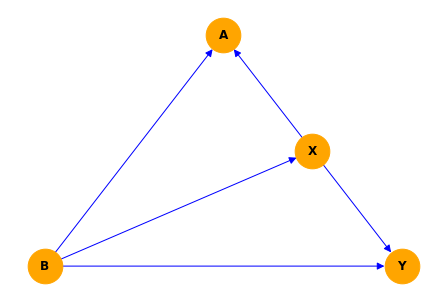

In [12]:
draw_fn(g, **nx_options)

In [13]:
actual_coefficients(dataset.__dict__)

B_A_coeff = 2
B_X_coeff = 3
B_Y_coeff = -1
X_A_coeff = 1.25
X_Y_coeff = 1


In [14]:
estimated_coefficients(g, df)

B A 1.999770
B X 2.999140
B Y -1.000160
X A 1.250070
X Y 1.000440


In [15]:
if dataset_index == 1:
    # total effect of B on Y = direct effect + effect via X
    print("%-11s %5.3f" % ("theoretical",
                           dataset.B_Y_coeff + dataset.B_X_coeff * dataset.X_Y_coeff))
    print()
    
    for sample in range(5):
        print("%-11s %5.3f" % ("empirical",
                               empirical_total_effect(g, "B", "Y", lambda *a: 1, lambda *a: 2)))

theoretical 2.000

empirical   2.008
empirical   2.004
empirical   2.005
empirical   1.998
empirical   2.003


In [16]:
if dataset_index == 3:
    # total effect of Z3 on Y = direct effect + effect via X and W
    print("%-11s %5.3f" % ("theoretical",
                           dataset.Z3_Y_coeff + dataset.Z3_X_coeff * dataset.X_W_coeff * dataset.W_Y_coeff))
    print()
    
    for sample in range(5):
        print("%-11s %5.3f" % ("empirical",
                               empirical_total_effect(g, "Z3", "Y", lambda *a: 1, lambda *a: 2)))

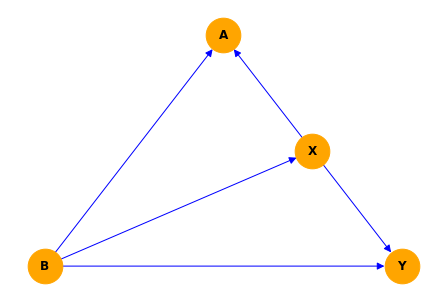

In [17]:
draw_fn(g, **nx_options)